#### Preprocessing

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import numpy as np

dataframe = pd.read_csv("UCI_Credit_Card.csv")

dataframe.head()
# dataframe.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [3]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

#### Dimension Reduction and Feature Selection

In [4]:
dataframe['SEX'] = dataframe['SEX'].astype(bool)
df1 = dataframe.copy()
subset = df1.head(n = 40)
subset.to_csv('subset_dataset.csv')
df1 = df1.drop(columns='ID')
rows, columns = df1.shape
for i in range(0, 29999, 1):
    df1.loc[df1['PAY_0'] < 0, 'PAY_0'] = 0
    df1.loc[df1['PAY_2'] < 0, 'PAY_2'] = 0
    df1.loc[df1['PAY_3'] < 0, 'PAY_3'] = 0
    df1.loc[df1['PAY_4'] < 0, 'PAY_4'] = 0
    df1.loc[df1['PAY_5'] < 0, 'PAY_5'] = 0
    df1.loc[df1['PAY_6'] < 0, 'PAY_6'] = 0

#taking average of the Payment and Bill Amounts
df1['PAY_AVG'] = (df1['PAY_AMT1'] + df1['PAY_AMT2'] + df1['PAY_AMT3'] + df1['PAY_AMT4'] + df1['PAY_AMT5'] + df1['PAY_AMT6']) / 6.0
df1['BILL_AVE'] = (df1['BILL_AMT1'] + df1['BILL_AMT2'] + df1['BILL_AMT3'] + df1['BILL_AMT4'] + df1['BILL_AMT5'] + df1['BILL_AMT6']) / 6.0

#droping Additional Columns as we have taken Average of both Pay and Bill
for col in ['BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']:
    df1 = df1.drop(columns=col)
for col in ['PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']:
    df1 = df1.drop(columns=col)


p = Rectangle(xy=(-0.25, 0), width=0.5, height=23364, angle=0)
p = Rectangle(xy=(0.75, 0), width=0.5, height=6636, angle=0)


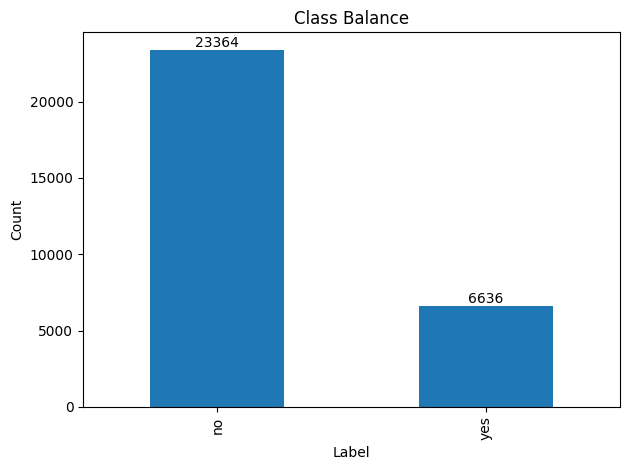

In [5]:
Y_Predict = "default.payment.next.month"
ax = df1[Y_Predict].map({0: "no", 1: "yes"}).value_counts().sort_index().plot(kind="bar")
ax.set_title("Class Balance")
ax.set_xlabel("Label")
ax.set_ylabel("Count")
for p in ax.patches:
    print(f"p = {p}")
    ax.annotate(text= int(p.get_height()), xy=(p.get_x()+p.get_width()/2, p.get_height()), ha="center", va="bottom")

plt.tight_layout()
plt.show()

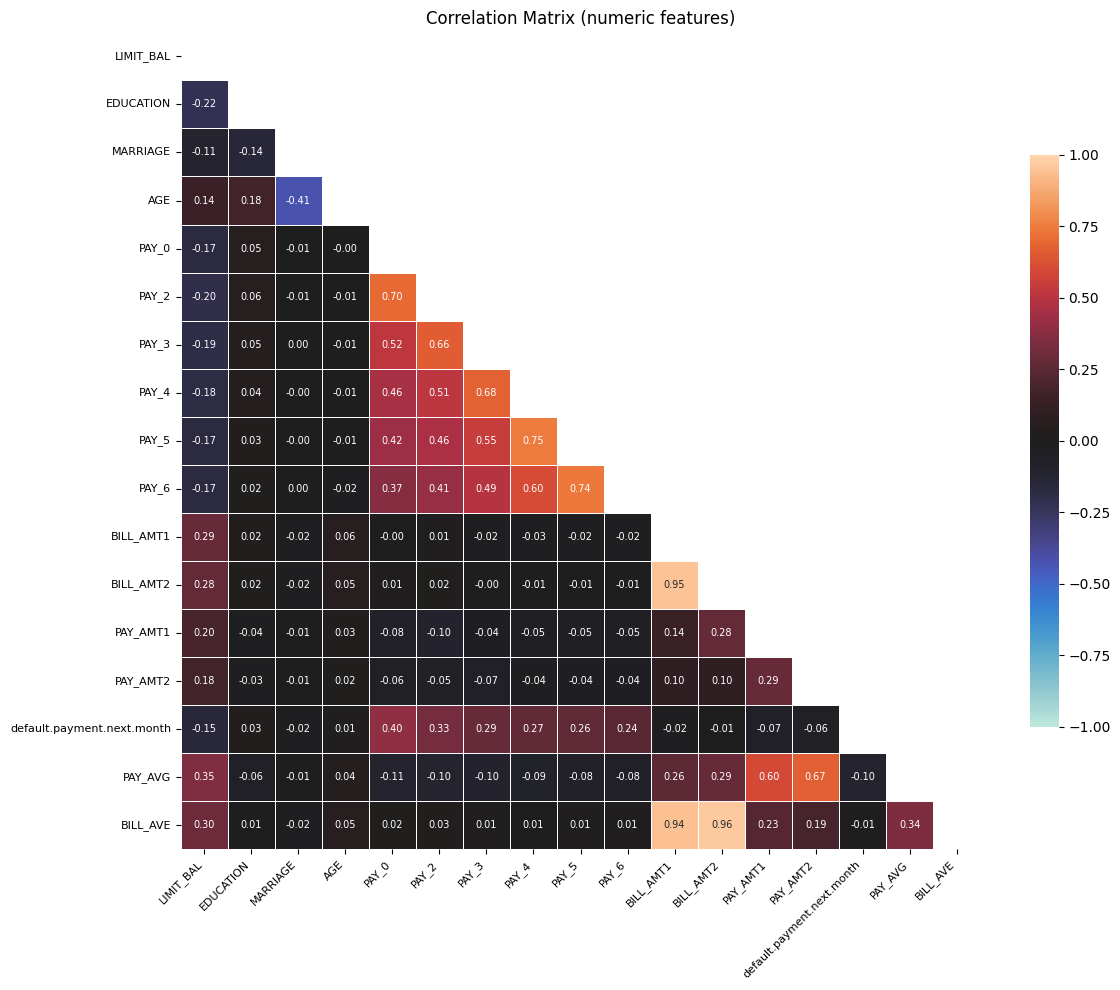

In [6]:
corr = df1.select_dtypes("number").corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr, mask=mask, annot=True, fmt=".2f",
    linewidths=0.5, linecolor="white",
    vmin=-1, vmax=1, center=0, square=False,
    cbar_kws={"shrink": 0.7}, annot_kws={"size": 7}
)
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.yticks(fontsize=8)
plt.title("Correlation Matrix (numeric features)")
plt.tight_layout()
plt.show()

In [20]:
feat_cols = dataframe.select_dtypes(include="number").columns.tolist()
if Y_Predict in feat_cols:
    feat_cols.remove(Y_Predict)

y_num = dataframe[Y_Predict]
if not pd.api.types.is_numeric_dtype(y_num):
    # Map common labels; fallback to factorize if custom labels exist
    y_num = y_num.map({"malignant": 0, "benign": 1})
    if y_num.isna().any():
        y_num = pd.Series(pd.factorize(dataframe[Y_Predict])[0], index=dataframe.index)

# --- 1) Drop highly correlated features (>0.95 with any earlier feature) ---
corr = dataframe[feat_cols].corr().abs()
upper = corr.where(np.triu(np.ones_like(corr, dtype=bool), k=1))
to_drop_high = [c for c in upper.columns if (upper[c] > 0.95).any()]

# --- 2) Drop features weakly related to label (|r(feature, y)| < 0.05) ---
r_xy = dataframe[feat_cols].apply(lambda s: s.corr(y_num)).fillna(0.0)
to_drop_weak = r_xy.index[r_xy.abs() < 0.05].tolist()

# --- Apply to the main DataFrame ---
drop_cols = sorted(set(to_drop_high) | set(to_drop_weak))
dataframe = dataframe.drop(columns=drop_cols)

In [21]:
df2 = df1.drop_duplicates()
Y = df2[Y_Predict]
X = df2.drop(columns=Y_Predict)

# Train Test split 
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, stratify=Y, random_state=42
)

print("Train:", X_train.shape, " Test:", X_test.shape)
print("Train ratio:", Y_train.value_counts(normalize=True).round(3).to_dict())
print("Test ratio:",  Y_test.value_counts(normalize=True).round(3).to_dict())
    

Train: (23952, 17)  Test: (5989, 17)
Train ratio: {0: 0.779, 1: 0.221}
Test ratio: {0: 0.779, 1: 0.221}


### Using different Classifier to check the accuracy for different models

In [ ]:
scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test  = pd.DataFrame(scaler.transform(X_test),  columns=X_test.columns,  index=X_test.index)

#### Logistic Regression

In [23]:
from sklearn.metrics import (confusion_matrix, classification_report)

clf = LogisticRegression(max_iter=1000, random_state = 16)
clf.fit(X_train, Y_train)
predicted_y = clf.predict(X_test)

cnf_matrix = confusion_matrix(Y_test, predicted_y)
print("Confusion matrix:\n", cnf_matrix)
print("Report:\n", classification_report(Y_test, predicted_y, zero_division=0))


Confusion matrix:
 [[4458  206]
 [ 918  407]]
Report:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89      4664
           1       0.66      0.31      0.42      1325

    accuracy                           0.81      5989
   macro avg       0.75      0.63      0.65      5989
weighted avg       0.79      0.81      0.78      5989



Text(0.5, 427.9555555555555, 'Predicted label')

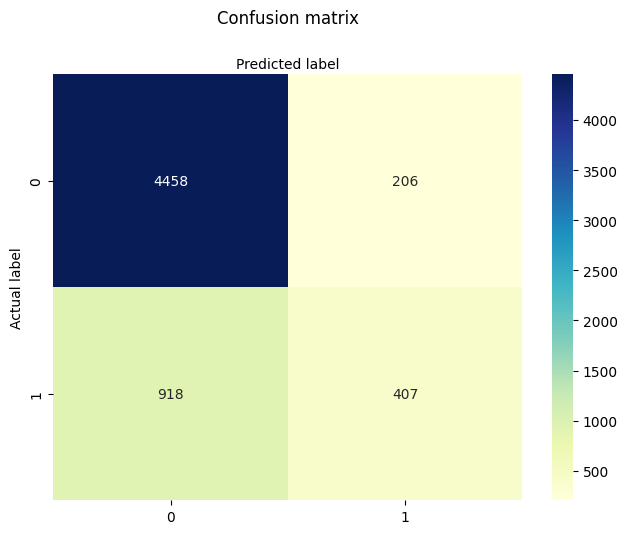

In [19]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

#heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot= True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')